<a href="https://colab.research.google.com/github/QuantAnalyticsTorch/quant_analytics_torch/blob/main/examples/FunctionApproximation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

In [2]:
device = None
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


In [3]:
import numpy as np

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
import torch
import numpy as np

BATCH_SIZE = 10**5

In [7]:
TOTAL_DRAWS = 10**6

xr = np.random.rand(TOTAL_DRAWS) * 2 * np.pi

X = np.zeros(shape=(TOTAL_DRAWS,1))
X[:,0] = xr
y = np.zeros(shape=(TOTAL_DRAWS,2))
y[:,0] = np.sin(xr)
y[:,1] = np.cos(xr)

Xt = torch.tensor(X, requires_grad=True, dtype=torch.float32).to(device)
y = torch.tensor(y, dtype=torch.float32).to(device)

X_train, X_val, y_train, y_val = train_test_split(Xt, y, test_size=0.2)

In [8]:
from torch.utils.data import Dataset, DataLoader

In [9]:
class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.x)

In [14]:
train_dataloader = DataLoader(CustomDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(CustomDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=True)

In [15]:
hidden_layer_size = 512

class FunctionApproximation(torch.nn.Module):
    def __init__(self):
        super(FunctionApproximation, self).__init__()
        self.regressor = torch.nn.Sequential(torch.nn.Linear(1, hidden_layer_size),
                                       torch.nn.ReLU(inplace=True),
                                       torch.nn.Linear(hidden_layer_size, hidden_layer_size),
                                       torch.nn.ReLU(inplace=True),
                                       torch.nn.Linear(hidden_layer_size, 1))
    def forward(self, x):
        output = self.regressor(x)
        return output

In [16]:
model = FunctionApproximation().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss(reduction="mean")

In [39]:
MAX_EPOCH = 3

# training loop
train_loss_list = list()
val_loss_list = list()

input = torch.zeros(size=(BATCH_SIZE,1))

for epoch in range(MAX_EPOCH):
    print("epoch %d / %d" % (epoch+1, MAX_EPOCH))
    model.train()
    # training loop
    temp_loss_list = list()
    for X_train, y_train in train_dataloader:
        input = X_train.clone().detach().requires_grad_(True)

        model_output = model(input)

        model_output.sum().backward(retain_graph=True, create_graph=True)
        dX = input.grad
        input.requires_grad = False

        loss0 = criterion(input=model_output, target=y_train[:,0:1])
        loss1 = criterion(input=dX, target=y_train[:,1:2])        

        loss = loss0 + 1 * loss1
        print(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # validation
    model.eval()

epoch 1 / 3
tensor(0.0390, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0405, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0401, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0395, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0377, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0377, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0382, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0364, device='cuda:0', grad_fn=<AddBackward0>)
epoch 2 / 3
tensor(0.0360, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0357, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0375, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0347, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0356, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0353, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0342, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0328, device='cuda:0', grad_fn=<AddBackward0>)
epoch 3 / 3
tensor(0.0333, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.033

In [40]:
yt = model(Xt)

In [41]:
import matplotlib.pyplot as plt

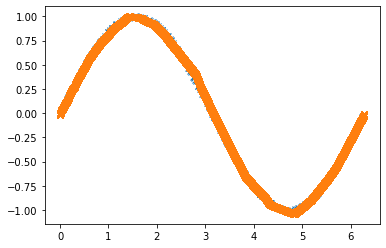

In [42]:
plt.plot(X[:200,0],y.cpu()[:200,0], 'x')
plt.plot(Xt.detach().cpu().numpy(),yt.detach().cpu().numpy(), 'x')